# Acquiring Data from Meteostat Source

## Installing Packages

In [1]:
pip install meteostat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install scikit-lego

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.9/230.9 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=75cc84cb00c07a6189c2d7d9380693b3fddcfd8447ca2aef135ce688a20b6be1
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=856919db96329c5d451316bc434017a75798ff9f84d41cb75fb3d1786700baaa
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [3]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing data from Metostat

https://github.com/meteostat/meteostat-python

---

https://meteostat.net/en/station/74206?t=2022-11-22/2022-11-29

In [4]:
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily, Hourly

import pandas as pd
import numpy as np

# function to get and process weather data for given (start, end) date
# when calling function start = datetime(year, month, day)
def get_weather_data(start, end):
    #get weather data

    # Create Point for location
    
    #tacoma/mcchord afb
    location = Point(47.15, -122.4833, 98)

    # Get daily data for 2018
    data = Hourly(location, start, end)
    data = data.fetch()

    #post process weather data
    data.reset_index(inplace=True)
    data['temp'] = data['temp']*9/5+32 #C to F
    data['dwpt'] = data['dwpt']*9/5+32
    data['time'] = data['time']-pd.Timedelta('8h') #US/Pacific time
    data['t'] = data['time']
    data['prcp_pre'] = data['prcp'].shift(1)
    data.set_index('time', inplace=True)

    return data

#format original data for auto regressive modeling
#the input order defines the number of past data points will be used
# when calling function dfx = independent variables, dfy = dependent variable
# order = however many past hours to include in data 

def prep_data(dfx, dfy=[], order=5):
    outx = np.array([])
    for col in dfx:
        x = [dfx[col].shift(m) for m in range(0,order)]
        x = np.array(x).T
        if len(outx)==0:
            outx = x
        else:
            outx = np.concatenate((outx,x), axis = 1)
    
    if len(dfy)>0:
        outy = np.array(dfy)
        return outx, outy
    else:
        return outx

# processing data 
def remove_nan_rows(d1, d2):
    id1 = np.isnan(d1).any(axis=1) #any rows in X contains nan
    id2 = np.isnan(d2).any(axis=1) #any y is nan
    id = ~(id1|id2) #rows having no nan in X and y

    return d1[id, :], d2[id, :], id

# function to call to get y_pred, rmse, r2 for any model
def predict(model, X, y_true=[]):
    y_pred = model.predict(X)
    if len(y_true)>0:
        #computer the performance matrices for this model
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2   = r2_score(y_true, y_pred)
        return y_pred, rmse, r2
    else:
        return y_pred

   

In [5]:
# get original historical data

# these are the dates we want to use
start = datetime(2021, 11, 1)
end = datetime.today()- pd.Timedelta('48h')


# call get_weather_data() function
data_hist = get_weather_data(start, end)

# Exploratory Data Analysis

Before diving deep into the data, it's important to learn more about our dataset and the historic weather patterns at our chosen location for further analysis.

In [6]:
data_hist

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,t,prcp_pre
time,,,,,,,,,,,,,
2021-10-31 16:00:00,57.20,31.82,38.0,0.0,NaN,350.0,1.8,NaN,1015.0,NaN,NaN,2021-10-31 16:00:00,NaN
2021-10-31 17:00:00,52.88,32.72,46.0,0.0,NaN,0.0,0.0,NaN,1015.1,NaN,NaN,2021-10-31 17:00:00,0.0
2021-10-31 18:00:00,44.06,37.94,79.0,0.0,NaN,0.0,0.0,NaN,1015.2,NaN,NaN,2021-10-31 18:00:00,0.0
2021-10-31 19:00:00,39.02,36.68,91.0,0.0,NaN,0.0,0.0,NaN,1015.2,NaN,NaN,2021-10-31 19:00:00,0.0
2021-10-31 20:00:00,37.22,35.06,92.0,0.0,NaN,190.0,5.4,NaN,1015.2,NaN,NaN,2021-10-31 20:00:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-15 08:00:00,44.60,44.60,100.0,0.0,NaN,10.0,9.0,NaN,992.0,NaN,3.0,2023-01-15 08:00:00,0.0
2023-01-15 09:00:00,46.40,46.40,100.0,0.2,NaN,0.0,0.0,NaN,992.3,NaN,7.0,2023-01-15 09:00:00,0.0
2023-01-15 10:00:00,46.40,46.40,100.0,0.5,NaN,260.0,9.4,NaN,993.6,NaN,8.0,2023-01-15 10:00:00,0.2


In [7]:
# Description of the variables in our historic data, including mean and stadard deviation, and quartiles
data_hist.describe()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,prcp_pre
count,10581.000000,10581.000000,10581.000000,10581.000000,0.0,10581.000000,10581.000000,0.0,10581.000000,0.0,6177.000000,10580.000000
mean,49.334880,43.503516,83.895379,0.179284,NaN,120.060108,8.501030,NaN,1017.853388,NaN,3.560142,0.179301
std,13.610769,10.121437,20.167913,0.569555,NaN,112.992384,8.004134,NaN,8.188921,NaN,2.558952,0.569579
min,10.580000,0.500000,19.000000,0.000000,NaN,0.000000,0.000000,NaN,977.600000,NaN,1.000000,0.000000
25%,39.560000,36.680000,70.000000,0.000000,NaN,0.000000,0.000000,NaN,1013.500000,NaN,2.000000,0.000000
50%,47.480000,43.340000,94.000000,0.000000,NaN,139.000000,7.600000,NaN,1018.100000,NaN,3.000000,0.000000
75%,57.560000,51.260000,100.000000,0.000000,NaN,210.000000,13.000000,NaN,1022.900000,NaN,5.000000,0.000000
max,95.720000,70.880000,100.000000,11.800000,NaN,360.000000,50.000000,NaN,1039.200000,NaN,20.000000,11.800000


In [8]:
# Correlation matrix between all the variables in historic data (could not run for all variables)
data_hist.corr()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,prcp_pre
temp,1.000000,0.794027,-0.639764,-0.054331,NaN,0.239525,0.207711,NaN,-0.161112,NaN,-0.393604,-0.054487
dwpt,0.794027,1.000000,-0.054208,0.066984,NaN,0.195031,0.069243,NaN,-0.213758,NaN,-0.244742,0.070235
rhum,-0.639764,-0.054208,1.000000,0.183722,NaN,-0.179415,-0.277668,NaN,-0.010692,NaN,0.387538,0.188651
prcp,-0.054331,0.066984,0.183722,1.000000,NaN,0.074658,0.165127,NaN,-0.252734,NaN,0.439774,0.639920
snow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wdir,0.239525,0.195031,-0.179415,0.074658,NaN,1.000000,0.560784,NaN,-0.134678,NaN,0.025818,0.069211
wspd,0.207711,0.069243,-0.277668,0.165127,NaN,0.560784,1.000000,NaN,-0.270672,NaN,0.051438,0.167844
wpgt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pres,-0.161112,-0.213758,-0.010692,-0.252734,NaN,-0.134678,-0.270672,NaN,1.000000,NaN,-0.123082,-0.255207
tsun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


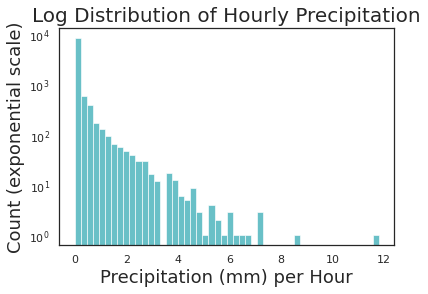

In [9]:
# Looking more closely at the precipitation distribution
import seaborn as sns

sns.set_theme(style="white")
sns.set_context(rc={"axes.titlesize":20,"axes.labelsize":18}) 
g1 = sns.histplot(data=data_hist, x="prcp", bins=50, color='#37abb5')
g1.set(xlabel='Precipitation (mm) per Hour', ylabel='Count (exponential scale)', title='Log Distribution of Hourly Precipitation')
g1.set_yscale("log")
g1 = sns.set(rc = {'figure.figsize':(15,8)})

We notice that there are a couple of very large outliers in the variable we are trying to predict.  When listing out all the unique variables for "prcp," we noticed there is a large outlier of 11.8 mm in one hour, with 6.8 mm in the hour prior.  This is one of the heaviest rains and skews the distirbution of precipitation with a long right tail.

Most notable is the frequency of 0 mm of rainfall per hour, meaning it will be tricky to predict an outcome that has a mode of 0 but can vary quite a lot!

In [10]:
# The rainiest hour in our data:
data_hist.loc[data_hist['prcp'] == 11.8]

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,t,prcp_pre
time,,,,,,,,,,,,,
2022-06-03 04:00:00,57.02,56.66,99.0,11.8,NaN,220.0,9.4,NaN,1007.7,NaN,NaN,2022-06-03 04:00:00,6.8


In [11]:
# Mode of precipitation is zero
data_hist['prcp'].mode()

0    0.0
dtype: float64

In [12]:
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots

subfig = make_subplots(specs=[[{"secondary_y": True}]])

# create two independent figures
fig = px.line(data_hist, y=['temp', 'dwpt'], color_discrete_map={
                "temp": "#1F77B4",
                "dwpt": "rgb(252, 141, 98)"})
fig2 = px.line(data_hist, y=['prcp'], color_discrete_map={
                "prcp": "rgb(136, 204, 238)"})


fig2.update_traces(yaxis="y2")

subfig.add_traces(fig.data + fig2.data)
subfig.layout.xaxis.title="Time"
subfig.layout.yaxis.title="Degrees (F) for Temperature and Dewpoint"
subfig.layout.yaxis2.title="mm of Rainfall for Precipitation"
subfig.update_layout(title_text="Historic Weather Data at Tacoma/McCord AFB", paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
subfig.show()

# Data Preparation 

Before we build our models, we need to choose our input features and process our data for training and testing. Our input variables, X = ['prcp_pre','dwpt', 'temp', 'wspd','coco'] and our dependent variable that we want to forecast is y = ['prcp']

Given our X,y we will split data_hist into training and testing sets using TimeSeriesSplit. In the previous section, we have already prepared two functions for further processing: **prep_data** and **remove_nan_rows**. 

**prep_data** will turn our training and testing data into numpy arrays with order = 12 lagged variables. **remove_nan_rows** will remove nan values from our data.

---

We will use the training data and testing data created at this step for our models. 


In [13]:
from sklearn.model_selection import TimeSeriesSplit
n_splits = 6
tss = TimeSeriesSplit(n_splits)

X = data_hist.drop(labels=['prcp','pres','snow', 'wpgt', 'tsun', 'wdir', 'rhum'], axis=1)
#xname = ['dwpt']
Y = data_hist['prcp']

for train_index, test_index in tss.split(X):
    x_train, x_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

df_y_tr = y_train.to_frame()
df_y_te = y_test.to_frame()

x_name = ['prcp_pre','dwpt', 'temp', 'wspd','coco']
y_name = ['prcp']
X_train, Y_train = prep_data(x_train[x_name], df_y_tr[y_name], order=12)
X_test, Y_test = prep_data(x_test[x_name], df_y_te[y_name], order=12)

X_train, Y_train, _ = remove_nan_rows(X_train, Y_train)
X_test, Y_test, _ = remove_nan_rows(X_test, Y_test)

# Method 0: Moving Average Method

The moving average method is a very simple time forecasting method.  This method is best used for long-term trends, so the quick changes in weather conditions and precipitation may not be as suitable for this method for hourly forecasting.  However, it is worth to see how it compares to our other models.

Over long time periods, this method may have some usefullness-- for example to assess changes due to climate change (years/decades) or the el nino and la nina effect (less than a decade), as well as shorter seasonal changes (dry and wet periods).



## Simple Moving Average with Window Size = 12 Hours

In [14]:
df = data_hist.copy()

df['SMA12'] = df['prcp'].rolling(window=12).mean()
df.tail()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,t,prcp_pre,SMA12
time,,,,,,,,,,,,,,
2023-01-15 08:00:00,44.60,44.60,100.0,0.0,NaN,10.0,9.0,NaN,992.0,NaN,3.0,2023-01-15 08:00:00,0.0,0.100000
2023-01-15 09:00:00,46.40,46.40,100.0,0.2,NaN,0.0,0.0,NaN,992.3,NaN,7.0,2023-01-15 09:00:00,0.0,0.075000
2023-01-15 10:00:00,46.40,46.40,100.0,0.5,NaN,260.0,9.4,NaN,993.6,NaN,8.0,2023-01-15 10:00:00,0.2,0.083333
2023-01-15 11:00:00,46.22,46.22,100.0,0.0,NaN,0.0,0.0,NaN,993.3,NaN,3.0,2023-01-15 11:00:00,0.5,0.066667
2023-01-15 12:00:00,45.86,45.86,100.0,0.0,NaN,170.0,7.6,NaN,993.7,NaN,3.0,2023-01-15 12:00:00,0.0,0.066667


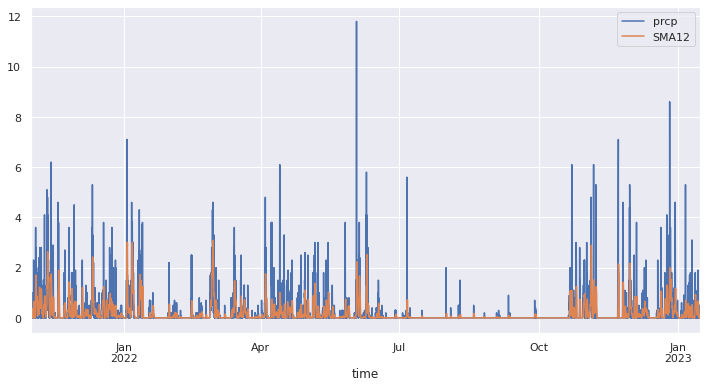

In [15]:
# Visualize this
df[['prcp', 'SMA12']].plot(label='precipitation', figsize=(12, 6))

Based on the visual, the SMA does a decent job with historic data-- the peaks are shorter and go on for longer, but it is a similar distribution.  In other words, it smoothed out the data.

Let's see the MSE and R2, and try to use it for forecasting.

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Create arrays from df
SMA12_y_true = df['prcp'].to_numpy(copy=True)
SMA12_y_pred = df['SMA12'].to_numpy(copy=True)

# Calculate MSE and R2 for all but first 12 values (no moving average before then)
rmse = np.sqrt(mean_squared_error(SMA12_y_true[12:], SMA12_y_pred[12:]))
r2   = r2_score(SMA12_y_true[12:], SMA12_y_pred[12:])

f"The MSE is {rmse}. The R^2 is {r2}."

'The MSE is 0.47254402145122026. The R^2 is 0.31228256040488955.'

In [17]:
# Save MSE and R2 for table
SMA_rmse = rmse
SMA_r2 = r2

In [18]:
# Display current forecast
now = datetime.today() - pd.Timedelta('8h')
st = now - pd.Timedelta('48h')
ed = now + pd.Timedelta('10h')
data_now = get_weather_data(st, ed)

data_now['SMA12'] = data_now['prcp'].rolling(window=12).mean()

fig = px.line(data_now, y=['prcp', 'SMA12'], title='Weather forecast')
fig.add_vline(x=now, line_width=3, line_dash="dash", line_color="green")
fig.show()

The limitations of applying a moving average mean is that using it for a prediction for the next hourly data is not very sufficient.  Not only was the general R2 low across all historic data, but forecasting into the future is not as easily doable, as seen from the timeplot above.

We will move onto other types of models and see how they work on both test and current forecasting after running on training data!

# Method 1: Multiple Linear Regression  

**Using order = 12 previous values to predict current time value**

### Example model with order = 2:
---

$AR(2)=y_t=b_1y_{t-1}+b_2y_{t-2}+c$



---
The training data and test data to be fitted on our linear regression model was previously created in above cells: X_train, Y_train, X_test, Y_test. 

In [19]:
#train a linear model
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

lreg = linear_model.LinearRegression()
# our linear model is named lr_model 

lr_model = lreg.fit(X_train, Y_train)

In [20]:
# Test the linear model

# we can call the function that we created earlier: predict(model, dfx, dfy)

y_pred, rmse, r2 = predict(lr_model, X_test, Y_test)

print('Linear model result:')
print(f'RMSE: {rmse}, R2:{r2}')

import plotly.express as px
#compare testing data results
out = pd.DataFrame({'True_value':Y_test[:,0], 'Pred_value':y_pred[:,0]})

fig = px.scatter(out, x='True_value', y='Pred_value', title='Precipitation Forecast')
fig.show()

Linear model result:
RMSE: 0.5215273979060358, R2:0.3729287594612015


In [21]:
# Save RMSE and R2 for table at end
test_MLR_rmse = rmse
test_MLR_r2 = r2

In [22]:
#now use the model to predict now 

now = datetime.today() - pd.Timedelta('8h')
st = now - pd.Timedelta('48h')
ed = now + pd.Timedelta('10h')
#ed = now
data_now = get_weather_data(st, ed)

# Xnow, ynow = prep_autoreg_data(data_now[xname], data_now[yname], order = 12)

Xnow, ynow = prep_data(data_now[x_name], data_now[y_name], order=12)
#remove rows having nan
Xnow, ynow, ids = remove_nan_rows(Xnow, ynow)
tm = data_now['t'].iloc[ids]

ynow_pred, rmse, r2 = predict(lr_model, Xnow, ynow) #call model using function to predict

# ynow_pred = lm.predict(Xnow) #call model to predict

# rmse = np.sqrt(mean_squared_error(ynow, ynow_pred))
# r2   = r2_score(ynow, ynow_pred)
print('Linear model result:')
print(f'RMSE: {rmse}, R2:{r2}')


Linear model result:
RMSE: 0.14751571839240915, R2:0.7210176476358363


In [23]:
# Save RMSE and R2 for table at end
current_MLR_rmse = rmse
current_MLR_r2 = r2

In [24]:
out = pd.DataFrame({'Time':tm, 'True_value':ynow[:,0], 'Pred_value':ynow_pred[:,0]})

pout = out[out.Time<now].copy()
pout['Time'] = pout['Time'] + pd.Timedelta('1h') #add one hour since the output is for forecast of the next one hour value
fig = px.line(pout, x='Time', y=['True_value', 'Pred_value'], title='Precipitation Forecast - Linear Model')
fig.add_vline(x=now, line_width=3, line_dash="dash", line_color="green")
fig.show()


Text(0.5, 1.05, 'Visualization of Betas of the Linear Model')

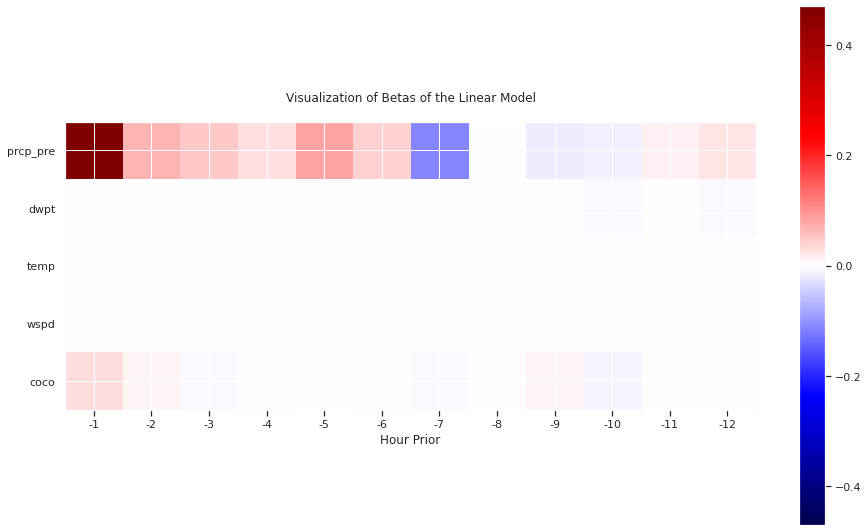

In [25]:
# Visualize the betas for the multiple linear regression model
fig = plt.figure()
ax = fig.add_axes([0.1, 0.2, 0.8, 0.9])

# Use matshow function to reshape data into array with different shades
cmax = np.abs(lr_model.coef_).max() 
cax = ax.matshow(np.reshape(lr_model.coef_, [5,12]), cmap='seismic', aspect = '1', vmax=cmax, vmin=-1*cmax)

# Create a colorbar on the side for reference
fig.colorbar(cax)

# Labels
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Hour Prior')
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax.set_xticklabels(list(range(-1, -13, -1)))
ax.set_yticklabels(x_name)
plt.title('Visualization of Betas of the Linear Model')

# Method 2: Random Forest Regression Model with Zero-Inflated Regressor

This method attempts to deal with the quantity of zeros in our target variable, precipitation. The model is a two-part model with a classifier and a regressor. First, we classify whether our target is zero or not with XGBoost. Then, we train the random forest regressor on all non-zero targets. 

In [26]:
from sklego.meta import ZeroInflatedRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier


zir = ZeroInflatedRegressor(
    classifier=XGBClassifier(n_estimators=400,learning_rate=0.1,max_depth=6, random_state=111),
    regressor=RandomForestRegressor(random_state=111)
)

print('ZIR (RFC+RFR) r²:', cross_val_score(zir, X_train, Y_train.ravel()).mean())

ZIR (RFC+RFR) r²: 0.13358077451983702


In [27]:
# fit the model
# Y has to be 'ravel' not Transpose 

zerinf = zir.fit(X_train, Y_train.ravel())

zer_pred, rmse_z, r2_z = predict(zerinf, X_test, Y_test.ravel())

print('Zero-inflated model result:')
print(f'RMSE: {rmse_z}, R2:{r2_z}')

Zero-inflated model result:
RMSE: 0.8341250206054254, R2:-0.6040759340231205


In [28]:
# Save RMSE and R2 for table at end
test_RFR_rmse = rmse_z
test_RFR_r2 = r2_z

In [29]:
#now use the model to predict now 

now = datetime.today() - pd.Timedelta('8h')
st = now - pd.Timedelta('48h')
ed = now + pd.Timedelta('10h')

data_now = get_weather_data(st, ed)

Xnow, ynow = prep_data(data_now[x_name], data_now[y_name], order=12)
#remove rows having nan
Xnow, ynow, ids = remove_nan_rows(Xnow, ynow)
tm = data_now['t'].iloc[ids]

znow_pred, rmse_znow, r2_znow = predict(zerinf, Xnow, ynow) #call model using function to predict

print('Zero-inflated model result (now):')
print(f'RMSE: {rmse_znow}, R2:{r2_znow}')

Zero-inflated model result (now):
RMSE: 0.09580346730586581, R2:0.8823308573159647


In [30]:
# Save RMSE and R2 for table at end
current_RFR_rmse = rmse_znow
current_RFR_r2 = r2_znow

In [31]:
# prediction output needs to be reshaped before plot b/c Y values were ravel'd
znowT = np.reshape(znow_pred, (-1, 1))

# plot now 

out = pd.DataFrame({'Time':tm, 'True_value':ynow[:,0], 'Pred_value':znowT[:,0]})

pout = out[out.Time<now].copy()
pout['Time'] = pout['Time'] + pd.Timedelta('1h') #add one hour since the output is for forecast of the next one hour value
fig = px.line(pout, x='Time', y=['True_value', 'Pred_value'], title='Precipitation Forecast - Zero Inflated')
fig.add_vline(x=now, line_width=3, line_dash="dash", line_color="green")
fig.show()


In [32]:
out

,Time,True_value,Pred_value
time,,,
2023-01-15 17:00:00,2023-01-15 17:00:00,0.9,0.509
2023-01-15 18:00:00,2023-01-15 18:00:00,1.4,1.204
2023-01-15 19:00:00,2023-01-15 19:00:00,0.9,0.800
2023-01-15 20:00:00,2023-01-15 20:00:00,0.4,0.630
2023-01-15 21:00:00,2023-01-15 21:00:00,0.4,0.546
2023-01-15 22:00:00,2023-01-15 22:00:00,0.3,0.683
2023-01-15 23:00:00,2023-01-15 23:00:00,0.0,0.000
2023-01-16 00:00:00,2023-01-16 00:00:00,0.0,0.000
2023-01-16 01:00:00,2023-01-16 01:00:00,0.0,0.000


# Method 3: Regression with added Artificial Neural Network 

At this step, we are using a keras Sequental model to forecast precipitation.

In [33]:
#train a ANN
from tensorflow import keras
from tensorflow.keras import layers

num_input = X_train.shape[1]

# we can adjust number of neurons inside layers 2 and 3 but final layer always = 1
# because we want only 1 output variable 
ann_model = keras.Sequential([
        layers.Dense(num_input, activation="relu", name="layer1"),
        layers.Dense(24, activation="relu", name="layer2"),
        layers.Dense(16, activation="relu", name="layer3"),
        layers.Dense(1, name="layer4"),
    ])

# Compile model
ann_model.compile(loss='mean_squared_error', optimizer='adam')

# Train model
ann_model.fit(X_train, Y_train,
          batch_size=400,
          epochs=200,
          verbose=0,
          validation_data=(X_test, Y_test))

In [35]:
#Test the ANN model

# call function defined above 
# use X_te and y_te already defined

y_pred, rmse_nn, r2_nn = predict(ann_model, X_test, Y_test)

print('ANN model result:')
print(f'RMSE: {rmse_nn}, R2:{r2_nn}')

import plotly.express as px
#compare testing data results
out = pd.DataFrame({'True_value':Y_test[:,0], 'Pred_value':y_pred[:,0]})

fig = px.scatter(out, x='True_value', y='Pred_value', title='Precipitation Forecast - ANN')
fig.show()

47/47 [==============================] - 0s 2ms/step
ANN model result:
RMSE: 0.5442347995375089, R2:0.3171343893191688


In [36]:
# Save RMSE and R2 for table at end
test_ANN_rmse = rmse_nn
test_ANN_r2 = r2_nn

In [37]:
#now use the ANN model to predict

# same deal as before 
model = ann_model

now = datetime.today() - pd.Timedelta('8h')
st = now - pd.Timedelta('48h')
ed = now + pd.Timedelta('10h')
#ed = now
data_now = get_weather_data(st, ed)

# Xnow, ynow = prep_autoreg_data(data_now[xname], data_now[yname], order = auto_order)
tm = data_now['t']

# #remove rows having nan
# Xnow_nn, ynow_nn, ids = remove_nan_rows(Xnow, ynow)
# tm_nn = tm.iloc[ids]

Xnow, ynow = prep_data(data_now[x_name], data_now[y_name], order=12)
#remove rows having nan
Xnow_nn, ynow_nn, ids = remove_nan_rows(Xnow, ynow)
tm_nn = tm.iloc[ids]

ynow_pred, rmse_nnow, r2_nnow = predict(model, Xnow_nn, ynow_nn) #call model to predict

# rmse = np.sqrt(mean_squared_error(ynow, ynow_pred))
# r2   = r2_score(ynow, ynow_pred)

print(f'RMSE: {rmse_nnow}, R2:{r2_nnow}')



2/2 [==============================] - 0s 6ms/step
RMSE: 0.15439150945370328, R2:0.6944044955287034


In [38]:
# Save RMSE and R2 for table at end
current_ANN_rmse = rmse_nnow
current_ANN_r2 = r2_nnow

In [39]:
import plotly.express as px

out = pd.DataFrame({'Time':tm_nn, 'True_value':ynow_nn[:,0], 'Pred_value':ynow_pred[:,0]})

pout = out[out.Time<now].copy()
pout['Time'] = pout['Time'] + pd.Timedelta('1h') #add one hour since the output is for forecast of the next one hour value
fig = px.line(pout, x='Time', y=['True_value', 'Pred_value'], title='Precipitation Forecast - ANN')
fig.add_vline(x=now, line_width=3, line_dash="dash", line_color="green")
fig.show()


# Comparison  of All Models

Now that we have used many different approaches, we want to compare them side-by-side.  Here, there are two tables: one for the model performance on the test data (or in the case of Model 0, on historic data), and another for model performance on 48 hour forescasting performance to predict the next hours.

RMSE gives us an absolute measure of fit, whereas R2 gives a relative measure of fit.

In [40]:
# Table for Test Model Performance
from tabulate import tabulate

table = [['Method #:','Method 0', 'Method 1', 'Method 2', 'Method 3'],
         ['Name', 'Simple Moving Average', 'Multiple Linear Regression',
          'Random Forest w 0-Infl', 'Regression with ANN'],
         ['rMSE', round(SMA_rmse, 4), round(test_MLR_rmse, 4), round(test_RFR_rmse, 4), round(test_ANN_rmse, 4)],
         ['R^2', round(SMA_r2, 4), round(test_MLR_r2, 4), round(test_RFR_r2, 4), round(test_ANN_r2, 4)],
]
print('Table for Comparison of Model Performance on Test Data')
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

Table for Comparison of Model Performance on Test Data
╒═════════════╤═══════════════════════╤════════════════════════════╤════════════════════════╤═════════════════════╕
│ Method #:   │ Method 0              │ Method 1                   │ Method 2               │ Method 3            │
╞═════════════╪═══════════════════════╪════════════════════════════╪════════════════════════╪═════════════════════╡
│ Name        │ Simple Moving Average │ Multiple Linear Regression │ Random Forest w 0-Infl │ Regression with ANN │
├─────────────┼───────────────────────┼────────────────────────────┼────────────────────────┼─────────────────────┤
│ rMSE        │ 0.4725                │ 0.5215                     │ 0.8341                 │ 0.5442              │
├─────────────┼───────────────────────┼────────────────────────────┼────────────────────────┼─────────────────────┤
│ R^2         │ 0.3123                │ 0.3729                     │ -0.6041                │ 0.3171              │
╘═════════════╧══

In [41]:
# Table for Current Day Forecasting Model Performance

table = [['Method #:', 'Method 1', 'Method 2', 'Method 3'],
         ['Name', 'Multiple Linear Regression',
          'Random Forest w 0-Infl. Regressor', 'Regression with added ANN'],
         ['rMSE', round(current_MLR_rmse, 4), round(current_RFR_rmse, 4), round(current_ANN_rmse, 4)],
         ['R^2', round(current_MLR_r2, 4), round(current_RFR_r2, 4), round(current_ANN_r2, 4)],
]
print('Table for Comparison of Model Performance on Current Forecasting Data')
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

Table for Comparison of Model Performance on Current Forecasting Data
╒═════════════╤════════════════════════════╤═══════════════════════════════════╤═══════════════════════════╕
│ Method #:   │ Method 1                   │ Method 2                          │ Method 3                  │
╞═════════════╪════════════════════════════╪═══════════════════════════════════╪═══════════════════════════╡
│ Name        │ Multiple Linear Regression │ Random Forest w 0-Infl. Regressor │ Regression with added ANN │
├─────────────┼────────────────────────────┼───────────────────────────────────┼───────────────────────────┤
│ rMSE        │ 0.1475                     │ 0.0958                            │ 0.1544                    │
├─────────────┼────────────────────────────┼───────────────────────────────────┼───────────────────────────┤
│ R^2         │ 0.721                      │ 0.8823                            │ 0.6944                    │
╘═════════════╧════════════════════════════╧══════════════